# Cleaning the text

In [ ]:
# First we install necessary libraries
pip install nltk
pip install scikit-learn
!pip install transformers==4.24.0
pip install simpletransformers

Add all imports that we'll use:

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
import matplotlib.pyplot as plt
import torch
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from simpletransformers.classification import ClassificationArgs, ClassificationModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving new_train.csv to new_train.csv


In [ ]:
# read the CSV file into a pandas dataframe
# 'new_train.csv' file is a combination of the 'train.csv' that
# provided by MRC at the begining of the a project and the extracted text from PDF files that were given later
df = pd.read_csv("new_train.csv", encoding="ISO-8859-1")
# define column names if the data doesn't have
# column_names = ["Category","Extracted text"]
# # set column names for the dataframe
# df.columns = column_names
df.head()

,Category,Extracted text
0,Correspondence,GV/MJ/\n4 August 1995\nClinic Date: 2 August 1...
1,Correspondence,PT/VMDJ/50055\nMrs Kathleen Allen\n23 Maple Ga...
2,Correspondence,CN/WSL\n17 February 1996\nClinic on 31-1-96\nD...
3,Correspondence,PT/VMDJ/50055\nMrs Kathleen Allen\n23 Maple Ga...
4,Correspondence,CENTRAL MIDDLESEX HOSPITAL NHS TRUST\nJJ.JML.\...


In [ ]:
# Set a seed for the random number generator
seed = 123

# Get a random sample of 20 rows for test the model on it
for_test = df.sample(n=20, random_state=seed)
# Drop these rows from the main DataFrame
df = df.drop(for_test.index)

In [ ]:
# Define the new order and names of columns
new_column_order = ["Extracted text", "Category"]

# Reindex the columns
df = df.reindex(columns=new_column_order)

In [ ]:
# download stopwords if not already downloaded

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('corpora')
nltk.download('wordnet')

In [ ]:
# Remove any leading or trailing white spaces
df['Extracted text'] = df['Extracted text'].str.strip()

# Remove any URLs or links
df['Extracted text'] = df['Extracted text'].apply(lambda x: re.sub(r'http\S+', '', str(x)))

# Remove any special characters, punctuation marks or numbers
df['Extracted text'] = df['Extracted text'].apply(lambda x: re.sub(r'[^A-Za-z\s]+', '', x))

# Convert all text to lowercase for consistency
df['Extracted text'] = df['Extracted text'].str.lower()

# Tokenize the text into words using the NLTK library
df['Extracted text'] = df['Extracted text'].apply(lambda x: word_tokenize(x))

# Remove any words that are less than 3 characters long
df['Extracted text'] = df['Extracted text'].apply(lambda x: [word for word in x if len(word) > 2])

# Lemmatize the words to their base forms
lemmatizer = WordNetLemmatizer()
df['Extracted text'] = df['Extracted text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Remove stop words
stop_words = set(stopwords.words('english'))
df['Extracted text'] = df['Extracted text'].apply(lambda x: [word for word in x if word not in stop_words])

# Join the words back together into a sentence
df['Extracted text'] = df['Extracted text'].apply(lambda x: ' '.join(x))

# Cleaning the Category column
# Convert all category names to lowercase for consistency
df['Category'] = df['Category'].str.lower()

# Remove any leading or trailing white spaces from categories names
df['Category'] = df['Category'].str.strip()

In [ ]:
# define a function for data anonymisation
def anonymize_text(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    anonymized_tokens = []

    for token in doc:
        if not token.ent_type_:
            anonymized_tokens.append(token.text)

    anonymized_text = " ".join(anonymized_tokens)
    return anonymized_text

In [ ]:
# Apply the anonymize_text function on the 'Extracted text' column
df['Extracted text'] = df['Extracted text'].apply(lambda x: anonymize_text(x))

In [ ]:
df.to_csv('/content/drive/MyDrive/anonymised_df_before_splitting.csv', index=False)
# df.to_csv('/content/drive/MyDrive/anonymised_df.csv', index=False)

In [ ]:
# # read the CSV file into a pandas dataframe
# df = pd.read_csv('/content/drive/MyDrive/anonymised_df.csv', encoding="ISO-8859-1")
df = pd.read_csv('/content/drive/MyDrive/anonymised_df_before_splitting.csv', encoding="ISO-8859-1")

In [ ]:
# Remove duplicates from the text
df = df.drop_duplicates(subset='Extracted text')

In [ ]:
# Define the list of special categories to remove based on the information shared by MRC
special_words = ['other', 'undated/miscellaneous', 'pre incident']

# Filter the DataFrame to exclude rows with special words in the 'Category' column
df = df[~df['Category'].isin(special_words)]

In [ ]:
# Define the category replacements
category_replacements = {

    'print out 1': 'printout 1',
    'print out 2': 'printout 2',
    'radiotherapy records': 'radiotherapy_records',
    'clinical records': 'clinical_records',
    'a & e admission  ': 'a&e records',
    'a&e admission': 'a&e records',
    'a_and_e_admission  ': 'a&e records',
    'a & e admission': 'a&e records',
    'a_and_e_admission': 'a&e records',
    'a+e admission  ': 'a&e records',
    'accident & emergency': 'a&e records',
    'accident and emergency': 'a&e records'
}

# Replace the categories in the 'Category' column
df['Category'].replace(category_replacements, inplace=True)

Using the Excel file including the correct list of all categories to then replace all the category names in the main dataset with new list

In [ ]:
# Read the Excel file into a DataFrame for new replacement of categories
excel_df = pd.read_excel('Categories and Subcategories.xlsx')

# define column names
excel_df_column_names = ["Old_Subcategory", "Category", "Subcategory", "Notes"]
# set column names for the dataframe
excel_df.columns = excel_df_column_names

In [ ]:
# Remove any leading or trailing white spaces
excel_df['Subcategory'] = excel_df['Subcategory'].str.strip()

# Remove any URLs or links
excel_df['Subcategory'] = excel_df['Subcategory'].apply(lambda x: re.sub(r'http\S+', '', str(x)))

# Remove any special characters, punctuation marks or numbers
# excel_df['Subcategory'] = excel_df['Subcategory'].apply(lambda x: re.sub(r'[^A-Za-z\s]+', '', x))

# Convert all category names to lowercase for consistency
excel_df['Subcategory'] = excel_df['Subcategory'].str.lower()

# The same cleaning steps on Old_Subcategory column as well
# Remove any leading or trailing white spaces
excel_df['Old_Subcategory'] = excel_df['Old_Subcategory'].str.strip()

# Remove any URLs or links
excel_df['Old_Subcategory'] = excel_df['Old_Subcategory'].apply(lambda x: re.sub(r'http\S+', '', str(x)))

# Remove any special characters, punctuation marks or numbers
# excel_df['Old_Subcategory'] = excel_df['Old_Subcategory'].apply(lambda x: re.sub(r'[^A-Za-z\s]+', '', x))

# Convert to lowercase for consistency
excel_df['Old_Subcategory'] = excel_df['Old_Subcategory'].str.lower()



In [ ]:
# Create a dictionary from column Old_Subcategory and column Subcategory of the Excel file
replacement_dict = dict(zip(excel_df['Old_Subcategory'], excel_df['Subcategory']))

# Replace values in the 'Category' column of df
df['Category'] = df['Category'].replace(replacement_dict)

# count the number of samples in each category
category_counts = df['Category'].value_counts()
print("Number of samples in each category:\n", category_counts)

Number of samples in each category:
 clinical records                 3847
correspondence                   2148
epr                               509
a&e records                       498
computerised records              358
outpatients                       351
cardiology                        212
theatre records                   204
biochemistry                      189
epr mixed reports                 188
radiology                         184
physiotherapy records             181
haematology                       165
occupational therapy records      151
ecg                               108
radiotherapy records               96
mental health                      94
computerised clinical records      76
nutrition                          59
histology                          36
chemotherapy records               34
speech and language therapy        30
gastroscopy                        15
endoscopy                          15
ecg trace                           1
Name: Categor

In [ ]:
# print(replacement_dict)

In [ ]:
# Identify the classes with more than one instance
valid_classes = category_counts[category_counts > 1].index.tolist()

# Filter the dataset to include only the valid classes
df = df[df['Category'].isin(valid_classes)]

# count the number of samples in each category after filttering
category_counts = df['Category'].value_counts()

In [ ]:
# count the number of unique categories
num_categories = len(df['Category'].unique())
print("Number of categories:", num_categories)

Number of categories: 24


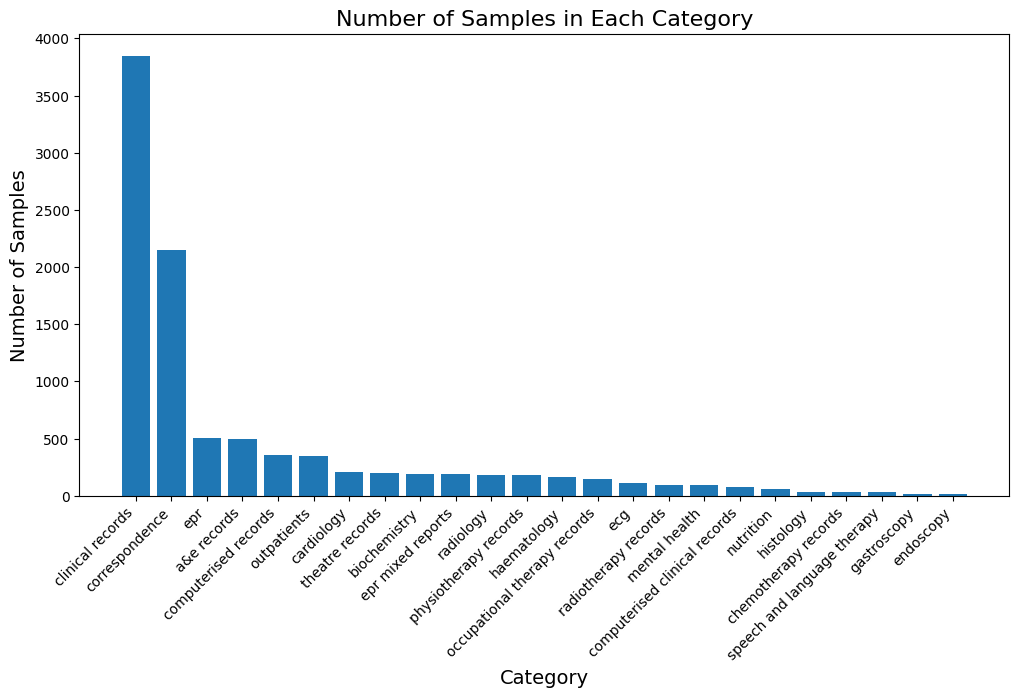

In [ ]:
# create a bar plot of the category counts
plt.figure(figsize=(12, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.title("Number of Samples in Each Category", fontsize=16)

# display the plot
plt.show()


In [ ]:
torch.cuda.is_available()
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
# Define the new names of columns
new_column_names = ["text", "labels"]
# Rename the columns
df = df.rename(columns=dict(zip(new_column_order, new_column_names)))
#
df.head()

,text,labels
0,watling medical centre watling avenue burnt oa...,correspondence
1,mr maple garden burnt oak edgware dear mr alle...,correspondence
2,cnwsl clinic trafford watling medical centre w...,correspondence
3,mr maple garden burnt oak edgware ojq dear mr ...,correspondence
4,central middlesex hospital nh trust jjjml traf...,correspondence


In [ ]:
# Define the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder to the category column in the training data
df["labels"] = label_encoder.fit_transform(df["labels"])
#
df.head()

,text,labels
0,watling medical centre watling avenue burnt oa...,7
1,mr maple garden burnt oak edgware dear mr alle...,7
2,cnwsl clinic trafford watling medical centre w...,7
3,mr maple garden burnt oak edgware ojq dear mr ...,7
4,central middlesex hospital nh trust jjjml traf...,7


In [ ]:
# Get the unique labels in the order they were encoded
unique_labels = label_encoder.classes_

# Iterate over the unique labels and their corresponding codes
for label, code in zip(unique_labels, label_encoder.transform(unique_labels)):
    print(f"Label: {label}, Code: {code}")

Label: a&e records, Code: 0
Label: biochemistry, Code: 1
Label: cardiology, Code: 2
Label: chemotherapy records, Code: 3
Label: clinical records, Code: 4
Label: computerised clinical records, Code: 5
Label: computerised records, Code: 6
Label: correspondence, Code: 7
Label: ecg, Code: 8
Label: endoscopy, Code: 9
Label: epr, Code: 10
Label: epr mixed reports, Code: 11
Label: gastroscopy, Code: 12
Label: haematology, Code: 13
Label: histology, Code: 14
Label: mental health, Code: 15
Label: nutrition, Code: 16
Label: occupational therapy records, Code: 17
Label: outpatients, Code: 18
Label: physiotherapy records, Code: 19
Label: radiology, Code: 20
Label: radiotherapy records, Code: 21
Label: speech and language therapy, Code: 22
Label: theatre records, Code: 23


# Train the model

---



First we split the data into train and test

In [ ]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# Define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='not majority')

# Apply oversampling to training data because the data is imbalance
train_df_over, _ = oversample.fit_resample(train_df, train_df['labels'])

In [ ]:
# Define hyperparameters
model_args = ClassificationArgs(
    num_train_epochs= 4,
    train_batch_size= 32,
    eval_batch_size= 32,
    learning_rate= 1e-4,
    save_model_every_epoch= False,
    overwrite_output_dir = True,
    save_eval_checkpoints= False
)


In [ ]:
# Create a directory to save the model
directory = '/content/drive/MyDrive/model/text_classification/'
os.makedirs(directory, exist_ok=True)

Check the models performance on the train dataset

In [ ]:
# Define the Simple Transformers model
model = ClassificationModel('roberta', 'roberta-base', num_labels=num_categories,
                            args=model_args, use_cuda=True)

# Train the model on the training set and save it in the directory
model.train_model(train_df_over, output_dir=directory)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/73944 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/2311 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/2311 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/2311 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/2311 [00:00<?, ?it/s]

(9244, 0.14408463760622067)

In [ ]:
# Make predictions on the test set
result, model_outputs, wrong_predictions = model.eval_model(train_df)
print(result)

# Get the predicted labels and true labels
y_pred = np.argmax(model_outputs, axis=1)
y_true = train_df["labels"].values

print("\nClassification Report:\n", classification_report(y_true, y_pred))

  0%|          | 0/7811 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/245 [00:00<?, ?it/s]

{'mcc': 0.9813090889367054, 'eval_loss': 0.057461258388903674}

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       398
           1       0.99      1.00      0.99       152
           2       1.00      1.00      1.00       170
           3       1.00      1.00      1.00        27
           4       1.00      0.97      0.98      3081
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00       287
           7       0.99      0.99      0.99      1722
           8       0.93      1.00      0.96        87
           9       1.00      1.00      1.00        12
          10       0.89      1.00      0.94       407
          11       0.99      0.99      0.99       150
          12       1.00      1.00      1.00        13
          13       1.00      0.99      1.00       133
          14       0.88      1.00      0.94        29
          15       1.00      1.00      1.00    

Check the models performance on the test dataset

In [ ]:
# Make predictions on the test set
result, model_outputs, wrong_predictions = model.eval_model(test_df)
print(result)

# Get the predicted labels and true labels
y_pred = np.argmax(model_outputs, axis=1)
y_true = test_df["labels"].values

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=unique_labels))

  0%|          | 0/1953 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/62 [00:00<?, ?it/s]

{'mcc': 0.8771274461248287, 'eval_loss': 0.6407814651968018}

Classification Report:
                                precision    recall  f1-score   support

                  a&e records       0.91      0.79      0.84       100
                 biochemistry       0.95      0.95      0.95        38
                   cardiology       0.97      0.93      0.95        42
         chemotherapy records       0.83      0.71      0.77         7
             clinical records       0.92      0.90      0.91       771
computerised clinical records       1.00      1.00      1.00        15
         computerised records       0.97      0.99      0.98        72
               correspondence       0.91      0.94      0.93       430
                          ecg       0.66      0.86      0.75        22
                    endoscopy       1.00      0.33      0.50         3
                          epr       0.76      0.96      0.85       102
            epr mixed reports       1.00      0.87      0.93 

Confusion Matrix

In [ ]:
label_codes = label_encoder.transform(unique_labels)

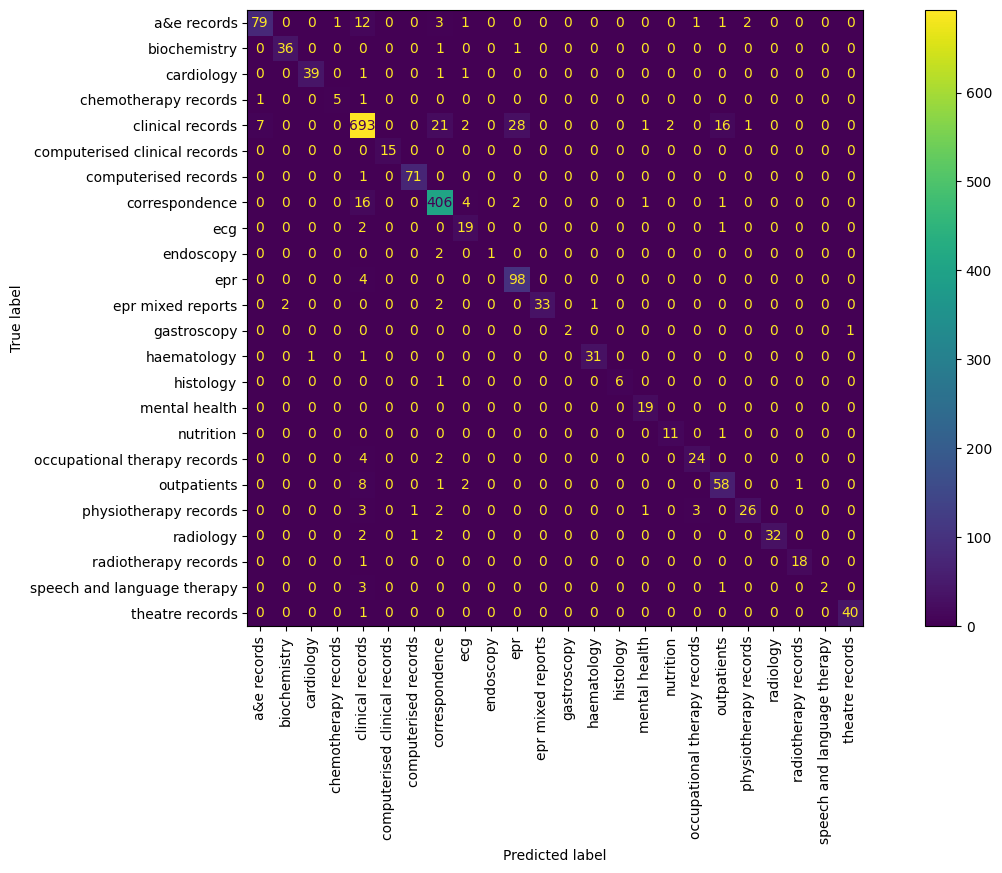

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=label_codes)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=unique_labels
)

cm_display.plot()
cm_display.ax_.set_xticklabels(unique_labels, rotation=90)
cm_display.figure_.set_size_inches(16, 8)

plt.show();